## Welcome To The Tutorial 3 Of Responsible AI

#### Welcome to our tutorial on A Guide to Fairness Measures in Machine Learning 

In this tutorial, we explore popular fairness measures and provide practical code examples using the Fairlearn library and ACS-PUMS data to assess and mitigate bias in machine learning models.


**Fairness in Machine Learning:**
Fairness in machine learning refers to the ethical and legal obligation to ensure that algorithms and models do not discriminate against or disadvantage particular individuals or groups based on attributes such as race, gender, age, or other sensitive features. Fairness aims to prevent bias and discrimination in algorithmic decision-making processes, promoting equitable outcomes for all individuals.

**Why Fairness Measures Are Needed:**
Fairness measures are essential in machine learning for several reasons:

1. **Mitigating Bias:** Machine learning models, when trained on biased data, can perpetuate and even exacerbate existing biases. Fairness measures help identify these biases, allowing data scientists and policymakers to take corrective actions.

2. **Legal and Ethical Compliance:** Discriminatory algorithms can lead to legal consequences and public backlash. Fairness measures help organizations avoid legal liability and adhere to ethical standards.

3. **Equitable Decision-Making:** Fairness measures ensure that decisions made by AI systems are fair and just, benefiting society as a whole. They promote fairness in contexts such as lending, hiring, healthcare, and criminal justice.

4. **Transparency and Accountability:** Fairness measures enhance the transparency of machine learning models. When disparities are detected, it becomes possible to understand and explain why certain decisions are being made.

5. **Improving Model Performance:** Addressing bias and ensuring fairness can lead to better model performance. Biased models may not perform optimally for all groups, leading to suboptimal outcomes.

In summary, fairness measures are needed to rectify biases, maintain ethical and legal compliance, achieve equitable decision-making, promote transparency, and ultimately enhance the performance and reliability of machine learning models in real-world applications.

#### Lets dive into more details by training an ML model on previously introduced ACS-PUMS data 

For practice we will resume with our own defined task and filter using the folktables library

In [124]:
import folktables
from folktables import ACSDataSource

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AR"], download=True)


In [125]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,f1_score
import numpy as np

#### Defining our own filter

In [126]:
def our_filter(data):
    df = data
    df = df[df['AGEP'] < 65]
    df = df[df['PINCP'] > 1000]
    df = df[df['WKHP'] > 2]
    df = df[df['PWGTP'] >= 1]
    return df

### Defining our own task

In [150]:
features=[ 'AGEP','SCHL', 'MAR','DIS','ESP','CIT','MIG','MIL', 'ANC','NATIVITY','DEAR',
        'DEYE','DREM','RAC1P','PUMA', 'OCCP','JWTR','GCL','PINCP',
        'ESR', 'OCCP', 'POWPUMA']

Hardworkers = folktables.BasicProblem(
                         features=features,
                        target='WKHP',
                        target_transform=lambda x: x > 45,
                        group='SEX',
                        preprocess=our_filter,
                        postprocess=lambda x: np.nan_to_num(x, -1),
                    )

In [151]:
features, label, group = Hardworkers.df_to_pandas(acs_data)

In [152]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [153]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

## 

#### We begin by accessing the models performance on each group using some commonly used ML evaluation metrics

array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'precision'}, ylabel='SEX'>,
        <Axes: title={'center': 'F1 score'}, ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

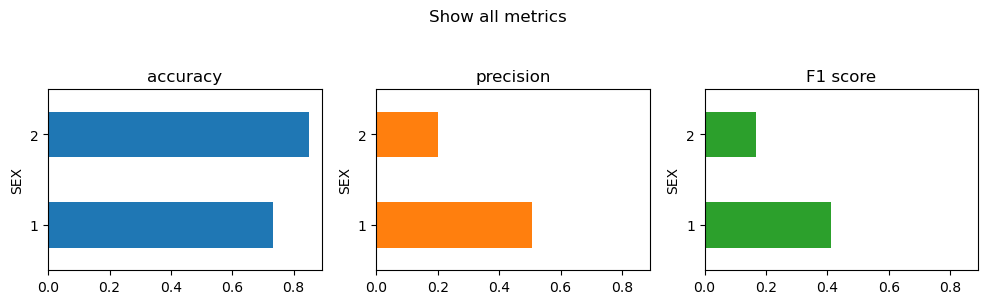

In [154]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "F1 score": f1_score,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# 

We can notice that the model clearly has **difference in predictive performance** on the two different ("1": Male, "2": Female) demographic groups. This already hints us that there is some discrimination.

But, this simple hint is not enough. ML is a statistical system and to understand/correct problems in such a system we need to formally access any property we are interested in. 

**Thus, we need formal definition of fairness** which gives us a **statistical analysis of the discrimination** observed in the predicted outcome of the model. There had been a plethora of fairness measures proposed in the literature. Let's look into some of the popular fairness measures in machine learning, along with examples to illustrate their usage:

### 1. Statistical Parity (Disparate Impact):

**Description:** Statistical parity, also known as demographic parity, measures whether the probability of a favorable outcome is consistent across different groups defined by a sensitive attribute (e.g., gender, race). It evaluates whether there is an imbalance in outcomes between these groups.

**Formally:** A Statistical or Demographic Parity difference is defined as 
$|E[h(X)=1| S=g] - E[h(X)=1| S=\hat{g}]|$ where $g$, $\hat{g}$ are a groups defined protected attribute $S$

**Code Example:**

In [155]:
from fairlearn.metrics import demographic_parity_difference

# Calculate demographic parity difference
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=group_test)


In [156]:
dp_diff

0.10664189707743046

The value **0.11516108875567818** gives the evaluation of discrimination of the model w.r.t Statistical Parity

Another way to impose Statistical Parity is by comparing the ratio between the probablities of the different groups. This way of measuring is particularly useful when the model prediction needs to comply with certain legal regulations like the 80% hiring contraints i.e. an unfavoured group must be at least **$0.8$** likely as the favoured group to be hired.  

In [157]:
from fairlearn.metrics import demographic_parity_ratio
dp_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=group_test)
dp_ratio

0.4161580172609584

Clearly there is a high discrimination between the two groups. Remember SP takes into account only the equality in prediction (correct or incorrect doesn't matter). 

-  To visualize the difference we need to plot positive prediction probabilities for each group.

- Let's define a function to compute only the probability for positive prediction and then visualize it through the metric frame functionality of FairLearn. 

2487
1303
1184


array([[<Axes: title={'center': 'Positive Predictions'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

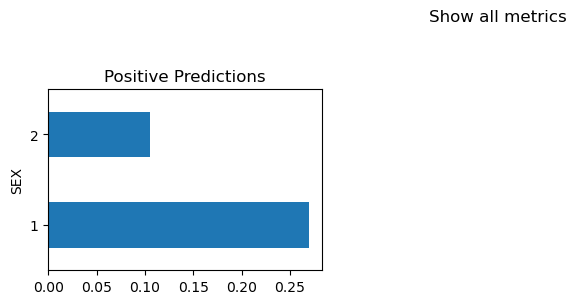

In [158]:
def pos_pred(y,g):
    print(len(g))
    return sum(y==True)/len(g)

metrics = {
    "Positive Predictions": pos_pred
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

**Statistical Parity** is one of the torch bearers in the field of accessing ML discrimination. But, clearly is not free of criticism as it **fails to consider the ground truth**. This brings us to our next fairness measure:

### 2. Equal Opportunity (True Positive Parity):

**Description:** Equal opportunity focuses on the true positive rate (sensitivity) and ensures that it is balanced across sensitive attribute groups.

**Formally:** An Equal Opportunity difference is defined as 
$|E[h(X)=1|Y=1, S=g] - E[h(X)=1|Y=1, S=\hat{g}]|$

**Code Example:**

In [159]:
from fairlearn.metrics import true_positive_rate_difference, true_positive_rate

E_Op= true_positive_rate_difference(y_test, y_pred, sensitive_features=group_test)

print(E_Op)

0.20072934472934476


array([[<Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

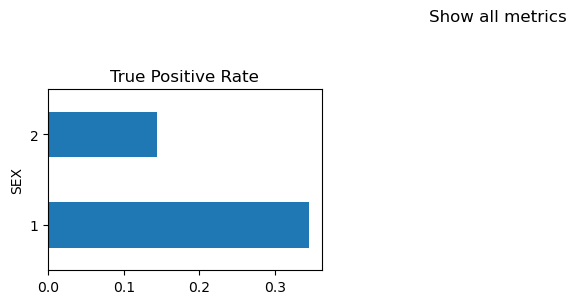

In [160]:
metrics = {
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

**Equal Opportunity** is a very popular measure and till date is widely used in research work requiring empherical evaluation of fairness. However, Equal Opportunity only looks into the positive class. There is another metric which takes into account both the positive and negaitive class (in case of binary prediction). 

### 3. Equalized Odds:

**Description:** Equalized odds assesses whether a model provides equal opportunity and fairness in both true positive rates (for positive class) and false positive rate (for negative class) for different groups.

**Formally:** An Equalized Odds difference is defined as 
$|E[h(X)=1|Y=1, S=g] - E[h(X)=1|Y=1, S=\hat{g}]| + |E[h(X)=1|Y=-1, S=g] -  E[h(X)=1|Y=-1, S=\hat{g}]|$

**Code Example:**

In [161]:
from fairlearn.metrics import false_positive_rate_difference,false_positive_rate

def eq_odd(y_test, y_pred, group_test):
    return true_positive_rate_difference(y_test, y_pred, sensitive_features=group_test)\
                + false_positive_rate_difference(y_test, y_pred, sensitive_features=group_test)

# Calculate equalized odds difference
eq_diff = eq_odd(y_test, y_pred,group_test)

print(eq_diff)

0.2556398358379695


I noticed some bug in the predefined Equalized odds difference function within the fairlearn library, thus I used a self defined function using some other predefined functions within the fairlearn library to measure Equalized Odds

array([[<Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>,
        <Axes: title={'center': 'False Positive Rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

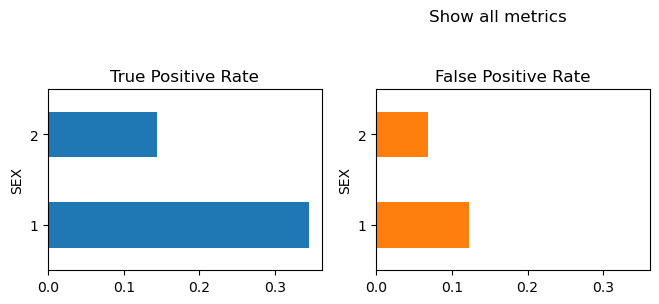

In [162]:
metrics = {
    "True Positive Rate": true_positive_rate,
    "False Positive Rate": false_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

So far we have learned how to evaluate fairness of an ML model given a protected attribute. But what if we have more than one protected attribute? Let's have a look.

We need to redefine our task with more than one attributes as protected. Let's take Race, and Sex as protected. 

In [163]:
features=[ 'AGEP','SCHL', 'MAR','DIS','ESP','CIT','MIG','MIL', 'ANC','NATIVITY','DEAR',
        'DEYE','DREM','PUMA', 'OCCP','JWTR','GCL','PINCP',
        'ESR', 'OCCP', 'POWPUMA']

Hardworkers = folktables.BasicProblem(
                         features=features,
                        target='WKHP',
                        target_transform=lambda x: x > 45,
                        group=['SEX','RAC1P'],
                        preprocess=our_filter,
                        postprocess=lambda x: np.nan_to_num(x, -1),
                    )

In [164]:
features, label, group = Hardworkers.df_to_pandas(acs_data)

In [165]:
group

,SEX,RAC1P
0,2,1
1,1,1
2,2,1
3,2,8
4,2,1
...,...,...
12430,1,1
12431,1,2
12432,2,1
12433,2,1



**We see that the attribute 'RACE' has more than two categorical value. To make our life simple let's binarize the attribute 'RACE' to 'White:1' and 'Non-white:2'.**

In [166]:
group['RAC1P'][group['RAC1P']!=1]=2

In [167]:
group

,SEX,RAC1P
0,2,1
1,1,1
2,2,1
3,2,2
4,2,1
...,...,...
12430,1,1
12431,1,2
12432,2,1
12433,2,1


In [168]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [169]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

#### Now we want to evaluate discrimination of the classifier based on 'Race' and 'Sex'. A very naive way would be to just measure discrimination individually on each of the protected attribute.

In [170]:
eq_diff_s = eq_odd(y_test, y_pred, group_test['SEX'])

print('Discrimition on Sex',eq_diff_s)

eq_diff_r = eq_odd(y_test, y_pred, group_test['RAC1P'])

print('Discrimition on Race',eq_diff_r)

Discrimition on Sex 0.2716459186662486
Discrimition on Race 0.055601490072433264


**We can also use the MetricFrame to visualize the true positive and false positive rates for each demgraphic group** 

array([[<Axes: title={'center': 'True Positive Rate'}, ylabel='SEX,RAC1P'>,
        <Axes: title={'center': 'False Positive Rate'}, ylabel='SEX,RAC1P'>,
        <Axes: title={'center': 'False Negative Rate'}, ylabel='SEX,RAC1P'>],
       [<Axes: ylabel='SEX,RAC1P'>, <Axes: ylabel='SEX,RAC1P'>,
        <Axes: ylabel='SEX,RAC1P'>],
       [<Axes: ylabel='SEX,RAC1P'>, <Axes: ylabel='SEX,RAC1P'>,
        <Axes: ylabel='SEX,RAC1P'>]], dtype=object)

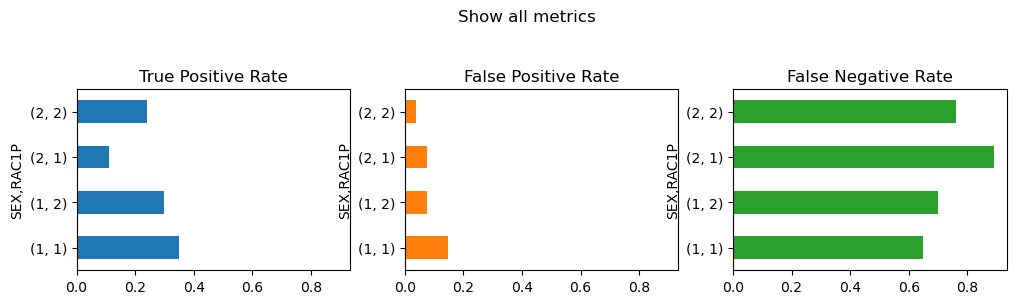

In [123]:
from fairlearn.metrics import false_negative_rate
metrics = {
    "True Positive Rate": true_positive_rate,
    "False Positive Rate": false_positive_rate,
    "False Negative Rate": false_negative_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

This gives a nice insight about the discriminations w.r.t different attributes, but still doesn't give an overall picture, like a single evaluated value to give overall discrimination accesment of the classifier.

To do so, we look into one such measure called **Multi-Max Mistreatment (MMM)** which gives the accesment of maximum discrimination observed in any of the class w.r.t any of the protected attribute.


**Formally:** A Multi-Max Mistreatment is defined as: 
$\max_{S_j}(\max|E[h(X)=1|Y=1, S_j=g_j] - E[h(X)=1|Y=1, S_j=\hat{g_j}]|,|E[h(X)=1|Y=-1, S_j=g_j] - E[h(X)=1|Y=-1, S_j=\hat{g_j}]|))$

where, $S_j$ denotes a protected attribute (Sex or Race) and $g_j, \hat{g_j}$ denotes groups (Male, Female) defined by the protected attribute $S_j$ (Sex).

**Code Example:**

In [171]:
from fairlearn.metrics import false_positive_rate_difference,false_negative_rate_difference

MMM=max([max(true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=group_test[S]),
        false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=group_test[S])) 
     for S in group_test.columns])
print('The Maximum Mistreatment observed over the multiple protected attributes is', MMM)

The Maximum Mistreatment observed over the multiple protected attributes is 0.20927635327635327


This is just a very basic way to look into discrimiantion w.r.t multiple protected attributes. However, there has been also a great deal of research going on in this direction specially on the subpopulation/ subgroups defined by the intersection of different groups e.g., 'Non-white Females'. 

To know more about discrimination w.r.t., multiple protected attribute please refer to the recent survey published in FAccT 2023, and is included in the reference below.

### References

- Roy, A., Horstmann, J., & Ntoutsi, E. (2023, June). Multi-dimensional Discrimination in Law and Machine Learning-A Comparative Overview. In Proceedings of the 2023 ACM Conference on Fairness, Accountability, and Transparency (pp. 89-100).

- Weerts, H., Dudík, M., Edgar, R., Jalali, A., Lutz, R., & Madaio, M. (2023). Fairlearn: Assessing and Improving Fairness of AI Systems. arXiv preprint arXiv:2303.16626.

- Roy, A., Iosifidis, V., & Ntoutsi, E. (2022, October). Multi-fairness under class-imbalance. In International Conference on Discovery Science (pp. 286-301). Cham: Springer Nature Switzerland.

- Ding, F., Hardt, M., Miller, J., & Schmidt, L. (2021). Retiring adult: New datasets for fair machine learning. Advances in neural information processing systems, 34, 6478-6490.

- Hardt, M., Price, E., & Srebro, N. (2016). Equality of opportunity in supervised learning. Advances in neural information processing systems, 29.

- Dwork, C., Hardt, M., Pitassi, T., Reingold, O., & Zemel, R. (2012, January). Fairness through awareness. In Proceedings of the 3rd innovations in theoretical computer science conference (pp. 214-226).